In [ ]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
%matplotlib inline

from pandas_datareader.data import DataReader

from datetime import datetime
from math import sqrt 
import random
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
crypto_df = pd.read_csv('./input/train.csv')
crypto_df.head(10)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.580000,2399.5000,2357.1400,2374.590000,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.530000,8.5300,8.5300,8.530000,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.194000,14013.8000,13666.1100,13850.176000,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.659600,7.6596,7.6567,7.657600,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.920000,25.9200,25.8740,25.877000,121.087310,25.891363,-0.008264
5,1514764860,6,173.0,738.302500,746.0000,732.5100,738.507500,335.987856,738.839291,-0.004809
6,1514764860,9,167.0,225.330000,227.7800,222.9800,225.206667,411.896642,225.197944,-0.009791
7,1514764860,11,7.0,329.090000,329.8800,329.0900,329.460000,6.635710,329.454118,NaN
8,1514764920,2,53.0,2374.553333,2400.9000,2354.2000,2372.286667,24.050259,2371.434498,-0.004079
9,1514764920,0,7.0,8.530000,8.5300,8.5145,8.514500,71.390000,8.520215,-0.015875


# Features
## 1. timestamp: All timestamps are returned as second Unix timestamps (the number of seconds elapsed since 1970-01-01 00:00:00.000 UTC). Timestamps in this dataset are multiple of 60, indicating minute-by-minute data.
## 2. Asset_ID: The asset ID corresponding to one of the crytocurrencies (e.g. Asset_ID = 1 for Bitcoin). The mapping from Asset_ID to crypto asset is contained in asset_details.csv.
## 3. Count: Total number of trades in the time interval (last minute).
## 4. Open: Opening price of the time interval (in USD).
## 5. High: Highest price reached during time interval (in USD).
## 6. Low: Lowest price reached during time interval (in USD).
## 7. Close: Closing price of the time interval (in USD).
## 8. Volume: Quantity of asset bought or sold, displayed in base currency USD.
## 9. VWAP: The average price of the asset over the time interval, weighted by volume. VWAP is an aggregated form of trade data.
## 10. Target: Residual log-returns for the asset over a 15 minute horizon.

In [3]:
asset_details = pd.read_csv('./input/asset_details.csv')

In [4]:
asset_details.style.background_gradient(cmap='gist_rainbow_r')

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


In [5]:
crypto_df['timestamp'] = pd.to_datetime(crypto_df['timestamp'], unit='s')
crypto_df.rename({'timestamp':'Date'}, axis=1, inplace=True)

In [6]:
def crypto_df_subset(asset_id, data):
    df = data[data['Asset_ID']==asset_id]
    return df

In [7]:
def plot_close_val(data_frame, column, stock):
    plt.figure(figsize=(16,6))
    plt.title(column + ' Price History for ' + stock)
    plt.plot(data_frame[column], color="#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)]))
    plt.xlabel('Date', fontsize=18)
    plt.ylabel(column + ' for '+ stock, fontsize=18)
    plt.show()

In [8]:
import mplfinance as mpf    

In [15]:
def mplplot(data_frame, stock):
    titletext = stock + 'MPL Finance OHLC Plot'
    mpf.plot(data_frame, type='candle', volume=True, mav=(7,14,28), figratio=(5,2), style='charles', title=titletext)

In [16]:
crypto_df['Date'] = pd.to_datetime(crypto_df.Date, utc=False)
crypto_df.head()

,Date,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2018-01-01 00:01:00,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218,0,0,1,1,2018,1,1,1
1,2018-01-01 00:01:00,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399,0,0,1,1,2018,1,1,1
2,2018-01-01 00:01:00,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643,0,0,1,1,2018,1,1,1
3,2018-01-01 00:01:00,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922,0,0,1,1,2018,1,1,1
4,2018-01-01 00:01:00,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264,0,0,1,1,2018,1,1,1


In [11]:
def time_series_features(df, dt_col='Date', label=None):
    
    df = df.copy()
    df['hour'] = df[dt_col].dt.hour
    df['dayofweek'] = df[dt_col].dt.dayofweek
    df['quarter'] = df[dt_col].dt.quarter
    df['month'] = df[dt_col].dt.month
    df['year'] = df[dt_col].dt.year
    df['dayofyear'] = df[dt_col].dt.dayofyear
    df['dayofmonth'] = df[dt_col].dt.day
    df['weekofyear'] = df[dt_col].dt.isocalendar().week
    
    return df

In [12]:
crypto_df = time_series_features(crypto_df)

In [13]:
def sn_pairplot(subsett):
    ax = sns.pairplot(subsett, hue='year', vars=['Volume', 
                                                 'Count', 'VWAP', 'Target'])
    

Bitcoin Cash


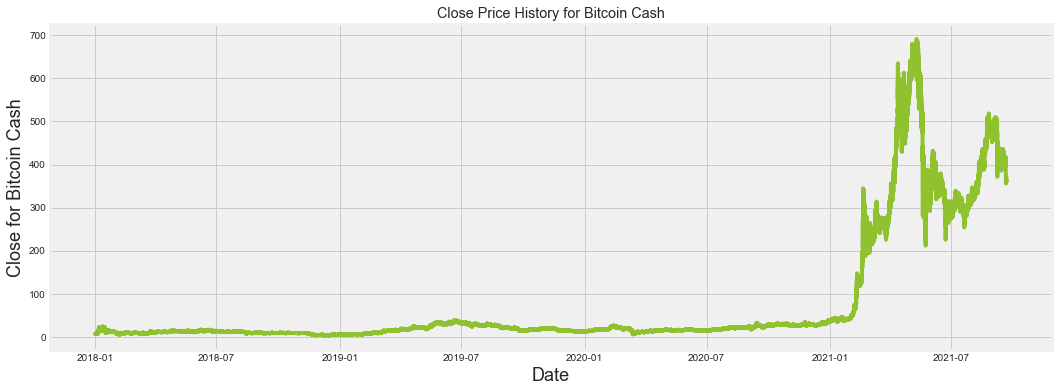

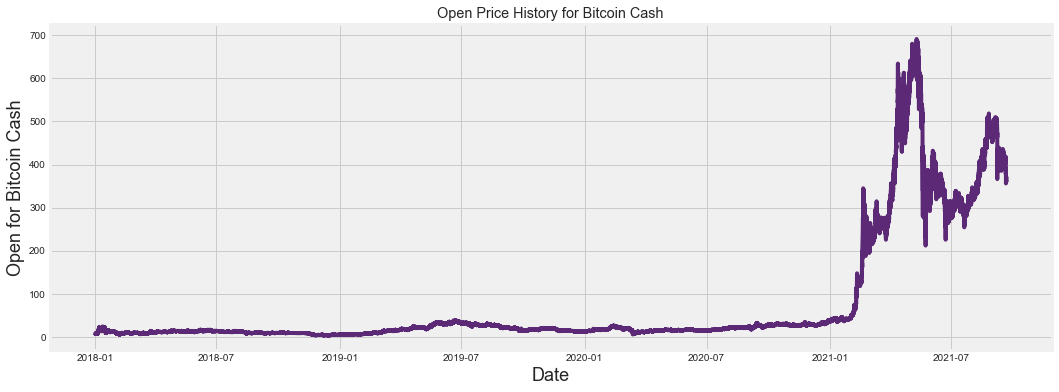

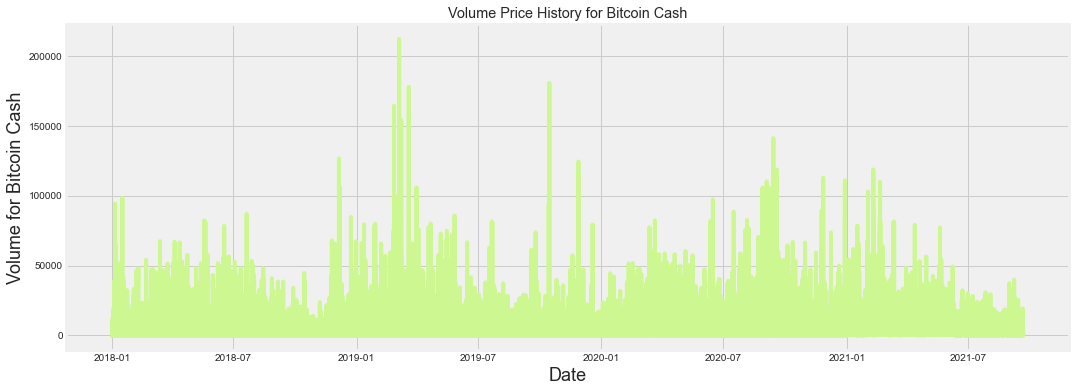

KeyError: 'Unrecognized kwarg="colume"'

In [14]:
asset_names = asset_details.Asset_Name.unique()
for i in range(0,14):
    subsett = crypto_df_subset(i, crypto_df)
    subsett['Date'] = pd.to_datetime(subsett.Date, utc=False)
    subsett.index = pd.DatetimeIndex(subsett['Date'])
    
    print(asset_names[i])
    plot_close_val(subsett, 'Close', asset_names[i])
    plot_close_val(subsett, 'Open', asset_names[i])
    plot_close_val(subsett, 'Volume', asset_names[i])
    
    mplplot(subsett[4000:5000], asset_names[i])
    subsett = subsett.sample(1000, random_state=42)
    sn_pairplot(subsett)
    
    del subsett